# Plot Results of Training Performance
We have run a training performance test on a few different machines, here we assess and contrast performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import json
import os

## Load in the Data
We are going to get the data from two sources: (1) Runs on my desktop computer (an [Intel i5 2550K](https://ark.intel.com/content/www/us/en/ark/products/65647/intel-core-i5-2550k-processor-6m-cache-up-to-3-80-ghz.html)) with and without a [GTX 670](https://www.geforce.com/hardware/desktop-gpus/geforce-gtx-670/specifications) GPU and (2) a single node on Theta with the MCDRAM in cache mode.

In [2]:
def load_results(dir_name):
    """Load a summary of the profiling experiment
    
    Args:
        dir_name (str): Path to a directory
    Returns:
        (dict) Dictionary of all the test files
    """
    
    output = {}
    
    # Get the system configuration
    with open(os.path.join(dir_name, 'host_info.json')) as fp:
        host_info = json.load(fp)
        
    host = host_info['hostname']
    output['hostname'] = 'theta' if host.startswith('nid') else host
    output['using_gpu'] = len(host_info['gpus']) > 0
    output['cores'] = int(host_info['accessible_cores'])
    
    # Get the run configuration
    with open(os.path.join(dir_name, 'run_params.json')) as fp:
        run_info = json.load(fp)
    
    output['n_batches'] = run_info['n_batches']
    output['inter_op'] = run_info['inter_op']
    
    # Load the run performance
    with open(os.path.join(dir_name, 'timings.json')) as fp:
        timing = json.load(fp)
        
    output.update(timing)
    
    # Compute the number of training entries per second
    output['entry_rate'] = np.multiply(output['batch_size'], output['rate'])
    
    # Compute how long it takes to assess 4.4M entries (size of my training set)
    output['epoch_time'] = 4.4e6 / output['entry_rate']
    
    return output
load_results('29Jan20-164241-nid03836')

{'hostname': 'theta',
 'using_gpu': False,
 'cores': 64,
 'n_batches': 64,
 'inter_op': 2,
 'batch_size': [32, 64, 128, 256, 1024, 2048],
 'rate': [0.6596916908401866,
  0.6213976945508349,
  0.5865819294847374,
  0.5289957944626924,
  0.3164309566201911,
  0.21331428186211945],
 'entry_rate': array([ 21.11013411,  39.76945245,  75.08248697, 135.42292338,
        324.02529958, 436.86764925]),
 'epoch_time': array([208430.69862663, 110637.68115473,  58602.21440881,  32490.80650529,
         13579.18658116,  10071.70022206])}

In [3]:
results = pd.DataFrame([load_results(os.path.dirname(f)) for f in glob(os.path.join('**', 'timings.json'))])

## Figure out Effect of Inter_op_threads
One of the key things to tune in TF for optimizing performance is how it parallelizes the computation graph

In [4]:
subset = results.query('hostname == "theta" and n_batches == 128').sort_values('inter_op')

Plot the results for the largest batch size

Text(0, 0.5, 'Normalized Rate (batch/s)')

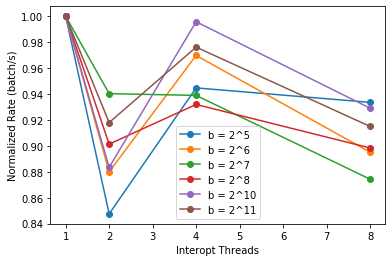

In [5]:
fig, ax = plt.subplots()

for i, b in enumerate(subset['batch_size'].iloc[0]):
    rates = subset['rate'].apply(lambda x: x[i])
    rates /= rates.iloc[0]
    ax.plot(subset['inter_op'], rates, 'o-', label=f'b = 2^{int(np.log2(b))}')

ax.legend()
ax.set_xlabel('Interopt Threads')
ax.set_ylabel('Normalized Rate (batch/s)')

*Finding*: Not much of an effect. The largest improvement we have seen is 2%

Figure out how long a single epoch will take for the fastest model

In [6]:
print(f'Minimum epoch time: {np.hstack(subset["epoch_time"]).min() :.2f}s')

Minimum epoch time: 8957.69s


## Compare Theta to Desktop GPU
Comparing my GTX670 to a KNL

Get a single plot for each

In [7]:
theta = results.query("hostname == 'theta' and inter_op == 1 and n_batches == 128")
assert len(theta) == 1
theta = theta.iloc[0]
print(f'Theta averaged over {theta["n_batches"]} batches')

Theta averaged over 128 batches


In [8]:
gpu = results.query("hostname == 'Logan-Desktop' and using_gpu")
assert len(gpu) == 1
gpu = gpu.iloc[0]
print(f'GPU averaged over {gpu["n_batches"]} batches')

GPU averaged over 512 batches


Plot the data 

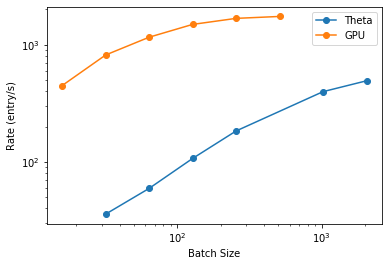

In [9]:
fig, ax = plt.subplots()

ax.loglog(theta['batch_size'], theta['entry_rate'], 'o-', label='Theta')
ax.loglog(gpu['batch_size'], gpu['entry_rate'], 'o-', label='GPU')

ax.set_xlabel('Batch Size')
ax.set_ylabel('Rate (entry/s)')
ax.legend()

*Finding*: The GPU is about 2x faster, which is especially visable at some batch sizes. We seem to saturate at around 2048 entries for the KNL processor